In [1]:
import torch
import numpy as np
import os
import pickle
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
writer = SummaryWriter()

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                #convert to tensor
    transforms.Normalize(mean=(0.5), std=(0.5)),#normalize [-1,1]
    transforms.RandomHorizontalFlip(0.5), #randomly flip horizontally
    transforms.Pad(4),                    #padding 4 pixels on all sides
    transforms.RandomCrop(size=(28, 28)), #randomly crop to 28*28
])

In [3]:
mnist_train = torchvision.datasets.FashionMNIST(root='./', train=True,download=True, transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5), std=(0.5))]))
train_dataset, valid_dataset = torch.utils.data.random_split(dataset= mnist_train,lengths=[59000, 1000])
train_dataset = torchvision.datasets.FashionMNIST(root='./', train=True,download=True, transform = transform)
mnist_test = torchvision.datasets.FashionMNIST(root='./', train=False,download=True, transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0.5), std=(0.5))]))

<class 'torchvision.datasets.mnist.FashionMNIST'>
<class 'torch.Tensor'>
label: 9
11_7


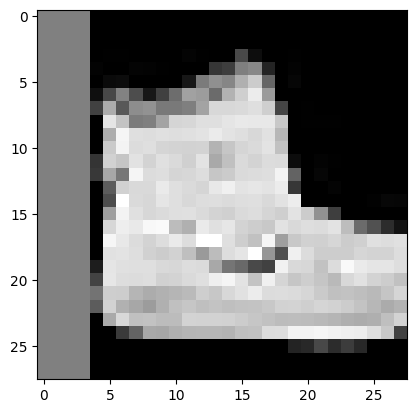

In [4]:
print(str(type(train_dataset)))
sample = next(iter(train_dataset))
image, label = sample
print(str(type(image)))
plt.imshow(image.squeeze(), cmap='gray')
print("label:" , label)
print(torch.cuda_version_1)

In [5]:
batch_size = 2048 
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    )
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    )
test_loader = DataLoader(
    dataset=mnist_test,
    batch_size=batch_size,
    shuffle=False,
    )

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)#5×5 Convolutional Layer with 32 filters
        self.pool1=nn.MaxPool2d(2,stride=2) #2×2 Max Pooling Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)#3×3 Convolutional Layer with 64 filters
        self.pool2=nn.MaxPool2d(2,stride=2) #2×2 Max Pooling Layer
        self.conv3 = nn.Conv2d(64, 96, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(96, 128, kernel_size=3, padding=2)
        self.conv5 = nn.Conv2d(128, 196, kernel_size=3, padding=2)
        self.conv6 = nn.Conv2d(196, 256, kernel_size=3, padding=2)
        self.fc1 = nn.Linear(256* 7* 7, 4096)#Fully-connected layer with 1024 output units
        self.fc2 = nn.Linear(4096, 2048)#Fully-connected layer with 10 output units
        self.fc3 = nn.Linear(2048, 1024)
        self.fc4 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()#ReLU Activation Layer
        #the forward function defining the flow of input data
    def forward(self,x):
        x = self.conv1(x)   
        x = self.relu(x)   
        x = self.pool1(x)    

        x = self.conv2(x)   
        x = self.relu(x)    
        x = self.pool2(x)
        
        x = self.conv3(x)   
        x = self.relu(x)    
        x = self.pool2(x)

        x = self.conv4(x)   
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv5(x)
        x = self.relu(x)
        x = self.conv6(x)
        x = self.relu(x)
        #print(x.shape)
        x = x.view(-1, 256*7*7)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x    

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(96, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv5): Conv2d(128, 196, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv6): Conv2d(196, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=12544, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=2048, bias=True)
  (fc3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc4): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
)


In [7]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()     # use default configuration 

# Initialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)      # we use Adam optimizer, with learning_rate=0.001

In [8]:
def train_loop(dataloader, model, loss_fn, optimizer, device, epoch):
    running_loss = 0.0
    total_loss = 0.0

    # Get a batch of training data from the DataLoader
    for batch, data in enumerate(dataloader):
        # Every data instance is an image + label pair
        img, label = data
        correct, total = 0, 0
        # Transfer data to target device
        img = img.to(device)
        label = label.to(device)

        # Zero your gradients for every batch
        optimizer.zero_grad()

        # Compute prediction for this batch
        logit = model(img)

        # compute the loss and its gradients
        loss = loss_fn(logit, label)
        # Backpropagation
        loss.backward()

        # update the parameters according to gradients
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()     # ! Don't forget to use .item() to retrieve loss value  
        total_loss += loss.item()
        # Calculate the index of maximum logit as the predicted label
        prob = F.softmax(logit, dim=1)
        pred = prob.argmax(dim=1)
         # record correct predictions
        correct += (pred == label).type(torch.float).sum().item()
        total += label.size(0)
        if batch % 50 == 99:
            print(' epoch {} loss: {:.4f}'.format(epoch+1, running_loss / 100))
            running_loss = 0.0
        accuracy = correct / total
    return total_loss / (batch+1), accuracy

In [9]:
def evaluate_loop(dataloader, model, loss_fn, device):

    # Get number of batches
    num_batches = len(dataloader)

    test_loss, correct, total = 0, 0, 0
    
    # Context-manager that disabled gradient calculation.
    with torch.no_grad():
        for data in dataloader:
            # Every data instance is an image + label pair
            img, label = data
            # Transfer data to target device
            img = img.to(device)
            label = label.to(device)

            # Compute prediction for this batch
            logit = model(img)

            # compute the loss
            test_loss += loss_fn(logit, label).item()    # ! Don't forget .item() again!!!

            # Calculate the index of maximum logit as the predicted label
            prob = F.softmax(logit, dim=1)
            pred = prob.argmax(dim=1)
            # record correct predictions
            correct += (pred == label).type(torch.float).sum().item()
            total += label.size(0)
    # Gather data and report
    test_loss /= num_batches
    accuracy = correct / total
    print("Test Error: \n   Accuracy: {:.2f}, Avg loss: {:.4f} \n".format(100*accuracy, test_loss))
    
    return test_loss, accuracy

In [10]:
epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
best_accuracy = 0.
log_dir = "./runs/lab2_1"
writer = SummaryWriter(log_dir=log_dir)
N_trainloss = []
N_trainaccuracy = []
M_valid_loss = []
M_valid_accuracy = []
for epoch in range(1, epochs+1):
    # train loop
    # set the module in training mode.
    model.train()
    train_loss, train_accuracy = train_loop(train_loader, model, loss_fn, optimizer, device, epoch)
    # save to tensorboard
    writer.add_scalar('train_loss', train_loss, epoch)
    N_trainloss.append(train_loss)
    N_trainaccuracy.append(train_accuracy)
    # save model weights
    save_path = 'valid_model.pth'
    torch.save(model.state_dict(), save_path)

    # validation loop
    # set the module in evaluation mode.
    model.eval()
    valid_loss, valid_accuracy = evaluate_loop(valid_loader, model, loss_fn, device)
    # save to tensorboard
    M_valid_loss.append(valid_loss)
    M_valid_accuracy.append(valid_accuracy)
    writer.add_scalar('valid_loss', valid_loss, epoch)
    writer.add_scalar('valid_accuracy', valid_accuracy, epoch)
    if valid_accuracy > best_accuracy:    # save the model with best validation accuracy
        save_path = 'my_model_best.pth'
        torch.save(model.state_dict(), save_path)
        best_accuracy = valid_accuracy

writer.close()
print("Finished Training.")

Test Error: 
   Accuracy: 40.20, Avg loss: 1.4855 

Test Error: 
   Accuracy: 56.90, Avg loss: 1.0143 

Test Error: 
   Accuracy: 69.50, Avg loss: 0.7723 

Test Error: 
   Accuracy: 76.40, Avg loss: 0.6480 

Test Error: 
   Accuracy: 82.10, Avg loss: 0.4925 

Test Error: 
   Accuracy: 80.40, Avg loss: 0.5161 

Test Error: 
   Accuracy: 83.20, Avg loss: 0.4675 

Test Error: 
   Accuracy: 83.50, Avg loss: 0.4457 

Test Error: 
   Accuracy: 84.40, Avg loss: 0.4222 

Test Error: 
   Accuracy: 84.80, Avg loss: 0.4034 

Test Error: 
   Accuracy: 87.50, Avg loss: 0.3507 

Test Error: 
   Accuracy: 88.20, Avg loss: 0.3278 

Test Error: 
   Accuracy: 86.30, Avg loss: 0.3565 

Test Error: 
   Accuracy: 87.30, Avg loss: 0.3421 

Test Error: 
   Accuracy: 88.70, Avg loss: 0.3201 

Test Error: 
   Accuracy: 88.40, Avg loss: 0.3105 

Test Error: 
   Accuracy: 90.30, Avg loss: 0.2763 

Test Error: 
   Accuracy: 89.20, Avg loss: 0.2847 

Test Error: 
   Accuracy: 86.80, Avg loss: 0.3320 

Test Error: 

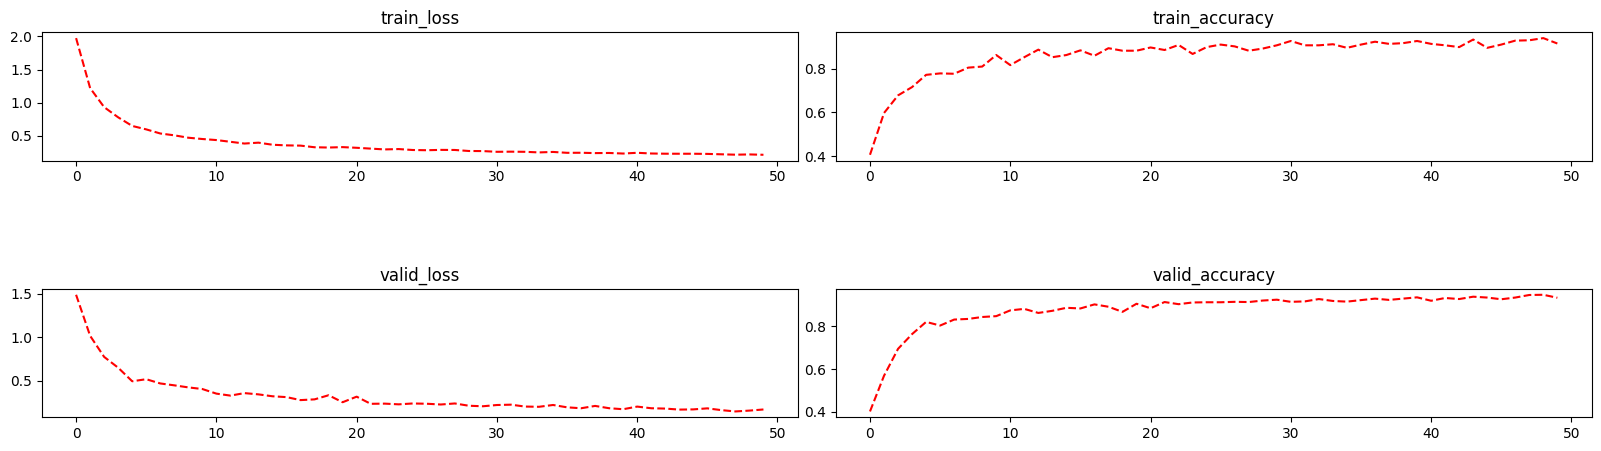

In [11]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(2,2,1)
ax.set_title("train_loss")
plt.plot(N_trainloss,'r--')
ax = fig.add_subplot(2,2,2)
ax.set_title("train_accuracy")
plt.subplots_adjust(wspace=0.05, hspace= 1)
plt.plot(N_trainaccuracy,'r--')
ax = fig.add_subplot(2,2,3)
ax.set_title("valid_loss")
plt.subplots_adjust(wspace=0.05, hspace= 1)
plt.plot(M_valid_loss,'r--')
ax = fig.add_subplot(2,2,4)
ax.set_title("valid_accuracy")
plt.subplots_adjust(wspace=0.05, hspace= 1)
plt.plot(M_valid_accuracy,'r--')

In [12]:
model = CNN()
model.to(device) 
# load the parameters to the same device
state_dict = torch.load('my_model_best.pth', map_location=device)
model.load_state_dict(state_dict)   # load parameters to model instance
model.eval()
test_loss, test_accuracy = evaluate_loop(test_loader, model, loss_fn, device)

Test Error: 
   Accuracy: 91.03, Avg loss: 0.2381 



In [18]:
class my_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.pool1=nn.MaxPool2d(2,stride=2) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
        self.pool2=nn.MaxPool2d(2,stride=2)
        self.conv3 =  nn.Conv2d(64, 128, kernel_size=3,padding=1)
        self.pool3=nn.MaxPool2d(2,stride=2)
        #self.conv4 =  nn.Conv2d(128, 256, kernel_size=3,padding=1)
        #self.pool4 = nn.MaxPool2d(2,stride=2)  
        self.fc1 = nn.Linear(128 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 10)
        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.conv1(x)   
        x = self.relu(x)   
        x = self.pool1(x)

        x = self.conv2(x)   
        x = self.relu(x)    
        x = self.pool2(x)

        x = self.conv3(x)   
        x = self.relu(x)    
        x = self.pool3(x)
        #x = self.conv4(x)   
        #x = self.relu(x)    
    
        x = x.view(-1, 128 * 3 * 3)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x    
    
model = my_model()
print(model)

my_model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU()
)


In [19]:
epochs = 50
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
best_accuracy = 0.
log_dir = "./runs/lab2_1"
writer = SummaryWriter(log_dir=log_dir)
for epoch in range(1, epochs+1):
    # train loop
    # set the module in training mode.
    model.train()
    train_loss = train_loop(train_loader, model, loss_fn, optimizer, device, epoch)
    # save to tensorboard
    writer.add_scalar('train_loss', train_loss, epoch)
    
    # save model weights
    save_path = 'valid_model.pth'
    torch.save(model.state_dict(), save_path)

    # validation loop
    # set the module in evaluation mode.
    model.eval()
    valid_loss, valid_accuracy = evaluate_loop(valid_loader, model, loss_fn, device)
    # save to tensorboard
    writer.add_scalar('valid_loss', valid_loss, epoch)
    writer.add_scalar('valid_accuracy', valid_accuracy, epoch)
    if valid_accuracy > best_accuracy:    # save the model with best validation accuracy
        save_path = 'my_model_best.pth'
        torch.save(model.state_dict(), save_path)
        best_accuracy = valid_accuracy

writer.close()
print("Finished Training.")

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10, Avg loss: 2.3037 

Test Error: 
   Accuracy: 9.10,

KeyboardInterrupt: 